In [1]:
%load_ext autoreload
%env CUDA_VISIBLE_DEVICES = 3

env: CUDA_VISIBLE_DEVICES=3


In [2]:
import os
import pandas as pd
import numpy as np
import tqdm
from typing import Tuple
import json 

import cv2
import PIL 

import torch
import torchvision.models as models
from torch.utils.data import Dataset
import torchvision.transforms as T
from torchvision.io import read_image
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from utils import generate_labels, ImagenetteDataset, get_norm_stats,\
                    get_transforms, train_procedure, get_augmented_transforms, load_model, plot_models
from models import VGG16, VGG11, VGG_tiny, Resnet, ResnetD, ResNext

from IPython.display import clear_output
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline
%autoreload 2

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
TRAIN_PATH = 'raw/train'
VAL_PATH = 'raw/val'
TRAIN_LABELS_CSV_PATH = 'raw/train/train_labels.csv'
VAL_LABELS_CSV_PATH = 'raw/val/val_labels.csv'

SAVES_PATH = "saves"

AUGMENT = True

SIZE = 224
batch_size = 16

In [5]:
if 'train_labels.csv' not in os.listdir(TRAIN_PATH):
    generate_labels(TRAIN_PATH, TRAIN_LABELS_CSV_PATH)
if 'val_labels.csv' not in os.listdir(VAL_PATH):
    generate_labels(VAL_PATH, VAL_LABELS_CSV_PATH)

In [6]:
train_labels, val_labels = pd.read_csv(TRAIN_LABELS_CSV_PATH), pd.read_csv(VAL_LABELS_CSV_PATH)
train_labels.head()

,filepath,class_name,class_num
0,raw/train/church/n03028079_10328.JPEG,church,0
1,raw/train/church/n03028079_3583.JPEG,church,0
2,raw/train/church/n03028079_6077.JPEG,church,0
3,raw/train/church/n03028079_3306.JPEG,church,0
4,raw/train/church/n03028079_9356.JPEG,church,0


In [7]:
len(train_labels), len(val_labels)

(9469, 3925)

In [8]:
mean, std = get_norm_stats(TRAIN_LABELS_CSV_PATH)

val_transform = get_transforms(mean, std)
train_transform = get_augmented_transforms(mean, std) if AUGMENT else get_transforms(mean, std)

train_dataset = ImagenetteDataset(TRAIN_LABELS_CSV_PATH, train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 

val_dataset = ImagenetteDataset(VAL_LABELS_CSV_PATH, val_transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

2


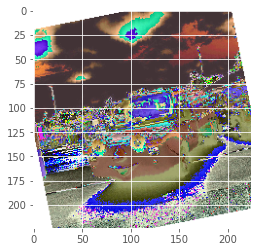

In [9]:
imgs, labels = next(iter(train_dataloader))
transf = T.ToPILImage(mode='RGB')
img = transf(imgs[0])
plt.imshow(img)
print(labels[0].item())

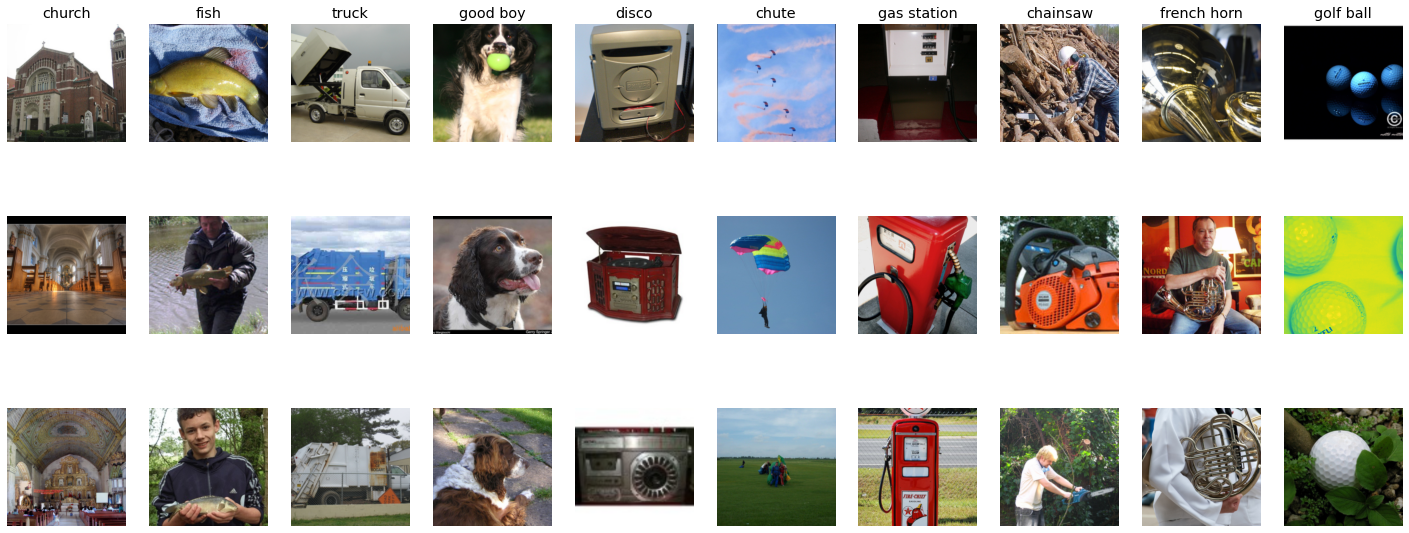

In [10]:
classes = list(train_labels['class_name'].unique())
num_classes = len(classes)
samples_per_class = 3

transform = T.Compose([
    T.Resize(SIZE), 
    T.CenterCrop(SIZE)
])

n_col, n_row = num_classes, samples_per_class
plt.figure(figsize=(25, 10))
for y, label in enumerate(classes):
    ids = np.random.choice(train_labels.loc[train_labels['class_name']==label].index, samples_per_class)
    for i, idx in enumerate(ids):
        img = PIL.Image.open(train_labels.iloc[ids[i]]['filepath'])
        img = transform(img)
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(img)
        plt.axis('off')
        if i == 0:
            plt.title(label)
    

In [11]:
class_names = [name for name in os.listdir(TRAIN_PATH) if name not in ['.ipynb_checkpoints', 'train_labels.csv']]

In [13]:
if 'model' in locals():
    del model
    
N_EPOCHS = 40
RESUME_TRAINING = False

model_name = 'resnext_lr4'
epoch = 0

model = ResNext()
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)

if RESUME_TRAINING:
    epoch = load_model(model, optimizer, os.path.join(SAVES_PATH, f'ckpts3/{model_name}_model.pt'))

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, min_lr=1e-7)
model.to(device);

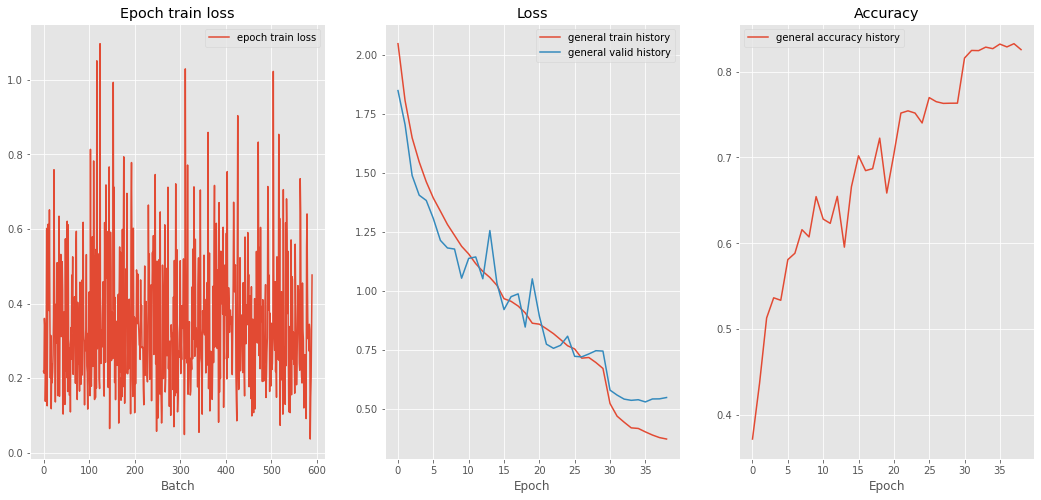

In [14]:
train_procedure(n_epochs=N_EPOCHS, model=model, train_iterator=train_dataloader, 
                val_iterator=val_dataloader, optimizer=optimizer,
                criterion=loss, saves_path=SAVES_PATH, start_epoch=epoch, 
                device=device, scheduler=scheduler, model_name=model_name)